In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf
import PIL
import PIL.Image
import pathlib
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from emnist import extract_training_samples, extract_test_samples
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

#### IMPORTING & COLLECTING DATA

In [3]:
x_train_l, y_train_l = extract_training_samples('letters')
x_test_l, y_test_l = extract_test_samples('letters')

x_train_d, y_train_d = extract_training_samples('digits')
x_test_d, y_test_d = extract_test_samples('digits')

train_data_generator = ImageDataGenerator(rescale=1/255.0, validation_split=0.2)

data_dir = pathlib.Path('tanda_baca')
train_ds = train_data_generator.flow_from_directory(
  data_dir,
  subset="training",
  seed=123,
  target_size=(28, 28),
  class_mode="categorical",
  batch_size=1,
  color_mode="grayscale")

val_ds = train_data_generator.flow_from_directory(
  data_dir,
  subset="validation",
  seed=123,
  target_size=(28, 28),
  class_mode="categorical",
  batch_size=1,
  color_mode="grayscale")

batch_index = 0
x_train_s = []
y_train_s = []
while batch_index <= train_ds.batch_index:
    data = train_ds.next()
    x_train_s.append(data[0])
    y_train_s.append(1)
    batch_index += 1
    
batch_index = 0
x_test_s = []
y_test_s = []
while batch_index <= val_ds.batch_index:
    data = val_ds.next()
    x_test_s.append(data[0])
    y_test_s.append(1)
    batch_index += 1
    
x_train_s, x_test_s = np.array(x_train_s), np.array(x_test_s)
y_train_s, y_test_s = np.array(y_train_s), np.array(y_test_s)

x_train_s = x_train_s.reshape(x_train_s.shape[0], 28, 28, 1)
x_test_s = x_test_s.reshape(x_test_s.shape[0], 28, 28, 1)

Found 488 images belonging to 4 classes.
Found 120 images belonging to 4 classes.


#### SHUFFLING AND SPLITTING DATA FOR BALANCING PURPOSES

In [3]:
idx = [x for x in range(len(y_train_d))]
np.random.shuffle(idx)

idx_test = [x for x in range(len(y_test_d))]
np.random.shuffle(idx_test)

split_x_train_d, split_y_train_d = x_train_d[idx[:488]], y_train_d[idx[:488]]
split_x_test_d, split_y_test_d = x_test_d[idx_test[:120]], y_test_d[idx_test[:120]]

idx = [x for x in range(len(y_train_l))]
np.random.shuffle(idx)

idx_test = [x for x in range(len(y_test_l))]
np.random.shuffle(idx_test)

split_x_train_l, split_y_train_l = x_train_l[idx[:488*2]], y_train_l[idx[:488*2]]
split_x_test_l, split_y_test_l = x_test_l[idx_test[:120*2]], y_test_l[idx_test[:120*2]]

#### NORMALIZING

In [4]:
split_x_train_d, split_x_test_d = split_x_train_d/255.0, split_x_test_d/255.0
split_x_train_l, split_x_test_l = split_x_train_l/255.0, split_x_test_l/255.0

#### REMOVING LAST DIMENSION

In [7]:
x_train_s =  x_train_s[:, :, :, 0]
x_test_s = x_test_s[:, :, :, 0]

#### CATEGORIZING INTO LETTERS & NON-LETTERS

In [6]:
y_train_l_new, y_test_l_new = np.array([0 for x in split_y_train_l]), np.array([0 for x in split_y_test_l])
y_train_d_new, y_test_d_new = np.array([1 for x in split_y_train_d]), np.array([1 for x in split_y_test_d])
y_train_s_new, y_test_s_new = np.array([1 for x in y_train_s]), np.array([1 for x in y_test_s])

#### COMBINING DATASETS

In [7]:
comb_x_train = np.concatenate((split_x_train_l, split_x_train_d, x_train_s), axis=0)
comb_y_train = np.concatenate((y_train_l_new, y_train_d_new, y_train_s_new), axis=0)

comb_x_test = np.concatenate((split_x_test_l, split_x_test_d, x_test_s), axis=0)
comb_y_test = np.concatenate((y_test_l_new, y_test_d_new, y_test_s_new), axis=0)

#### ADDING BACK THE LAST DIMENSION OF IMAGE CHANNEL

In [8]:
comb_x_train = comb_x_train.reshape(comb_x_train.shape[0], 28, 28, 1)
comb_x_test = comb_x_test.reshape(comb_x_test.shape[0], 28, 28, 1)

In [9]:
comb_x_test.shape

(480, 28, 28, 1)

#### MODEL BUILDING & TRAINING

In [10]:
model = Sequential([
    Conv2D(32, (3, 3), input_shape=comb_x_train.shape[1:], activation="relu"),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation="relu"),
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')])

model.compile(optimizer = "adam", loss="binary_crossentropy", metrics=["acc"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 32)        9248      
                                                                 
 flatten (Flatten)           (None, 3872)              0         
                                                                 
 dense (Dense)               (None, 32)                123936    
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                        

In [11]:
model.fit(comb_x_train, comb_y_train, epochs=20, validation_data=(comb_x_test, comb_y_test))

Epoch 1/20
61/61 [==============================] - 5s 5ms/step - loss: 0.4634 - acc: 0.7428 - val_loss: 0.4259 - val_acc: 0.7771
Epoch 2/20
61/61 [==============================] - 0s 3ms/step - loss: 0.3975 - acc: 0.7946 - val_loss: 0.3605 - val_acc: 0.8125
Epoch 3/20
61/61 [==============================] - 0s 3ms/step - loss: 0.3675 - acc: 0.8094 - val_loss: 0.3478 - val_acc: 0.8188
Epoch 4/20
61/61 [==============================] - 0s 3ms/step - loss: 0.3427 - acc: 0.8212 - val_loss: 0.3384 - val_acc: 0.8250
Epoch 5/20
61/61 [==============================] - 0s 3ms/step - loss: 0.3175 - acc: 0.8453 - val_loss: 0.3332 - val_acc: 0.8375
Epoch 6/20
61/61 [==============================] - 0s 3ms/step - loss: 0.2982 - acc: 0.8555 - val_loss: 0.3097 - val_acc: 0.8583
Epoch 7/20
61/61 [==============================] - 0s 3ms/step - loss: 0.2729 - acc: 0.8678 - val_loss: 0.3096 - val_acc: 0.8625
Epoch 8/20
61/61 [==============================] - 0s 3ms/step - loss: 0.2583 - acc: 0.87

In [12]:
comb_x_test[5].shape

(28, 28, 1)

1/1 [==============================] - 0s 93ms/step
[[0.]]


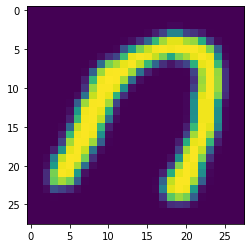

In [13]:
# comb_x_test.shape
res = model.predict(np.array(comb_x_test[5]).reshape(1, 28, 28, 1))
print(np.round(res))

plt.imshow(np.array(comb_x_test[5]))

In [14]:
model.save('model\check_letter.h5')